In [350]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV


#### Helper function for model decision threshold

In [351]:
# Give threshold for chosen parameter for artifact = 0.35

def threshold_at_precision(y_true, y_proba, min_precision=0.35):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # precision and recall are 1 object longer than thresholds
    precision = precision[:-1]
    recall = recall[:-1]

    mask = precision >= min_precision
    best_idx = np.argmax(recall[mask])

    return thresholds[mask][best_idx]

### Splitting Train/Test and OHE categorical columns

In [352]:
df = pd.read_parquet("../../01_data/processed/dataset_clean.parquet")

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((24382, 19), (6096, 19))

In [353]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

cat_cols, num_cols

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'day_of_week', 'poutcome'],
       dtype='object'),
 Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype='object'))

In [354]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

### Logistic regression (baseline)

In [355]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  #class imbalance
    random_state=42
)

In [356]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", lr),
    ]
)

model.fit(X_train, y_train)

c:\Users\JoepSticker\miniconda3\envs\py311\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

#### Baseline test (No restriction on precision/recall/other metrics)

In [357]:
lr_pred = model.predict(X_test)
lr_proba = model.predict_proba(X_test)[:, 1]

confusion_matrix(y_test, lr_pred)

array([[4374,  950],
       [ 274,  498]])

In [358]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      5324
           1       0.34      0.65      0.45       772

    accuracy                           0.80      6096
   macro avg       0.64      0.73      0.66      6096
weighted avg       0.87      0.80      0.82      6096



In [359]:
precision, recall, thresholds = precision_recall_curve(y_test, lr_proba)

avg_precision = average_precision_score(y_test, lr_proba)
avg_precision

0.42885703765389444

#### ROC - AUC

In [360]:
lr_AUC = roc_auc_score(y_test, lr_proba) #Logistic regression AUC as baseline
lr_AUC

0.7882092723146336

#### Precision-Recall curve

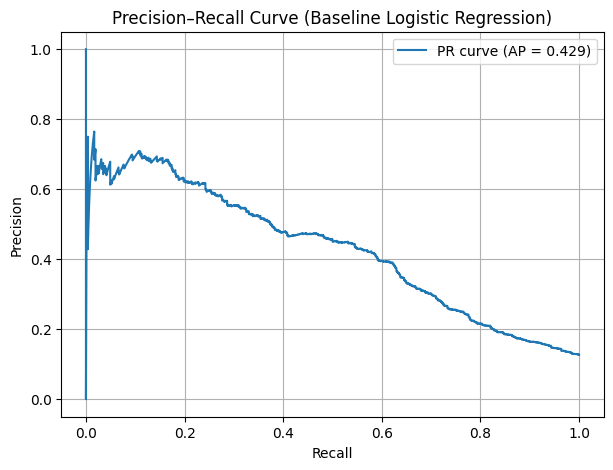

In [361]:
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR curve (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Baseline Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### Artifact Metrics

In [362]:
# Precision 0.3, 0.35, 0.4, 0.45, 0.50 with max recall (chosen to make recall heavy artifact metric due to cost of missed opportunity being higher than cost of non-prospect being mislabeled as opportunity)
# Precision of calling everyone = TP/total test set = 0.13

constraints = [0.30, 0.35, 0.40, 0.45, 0.50]

for p in constraints:
    r = recall[:-1][precision[:-1] >= p].max()
    print(f"precision ≥ {p:.2f} → recall = {r:.3f}")


precision ≥ 0.30 → recall = 0.701
precision ≥ 0.35 → recall = 0.637
precision ≥ 0.40 → recall = 0.592
precision ≥ 0.45 → recall = 0.531
precision ≥ 0.50 → recall = 0.374


In [363]:
# Accompanying threshold = 0.512, meaning a call gets made when model predicts y=1 with 51% certainty. Threshold only helps create confusion matrix and does not explain model performance in itself.

lr_threshold = threshold_at_precision(y_test, lr_proba, 0.35)
lr_pred = (lr_proba >= lr_threshold).astype(int)
lr_threshold

np.float64(0.5117104735311018)

#### Confusion Matrix & Classification Report

In [364]:
# Model performance with chosen parameter

confusion_matrix(y_test, lr_pred)

array([[4411,  913],
       [ 280,  492]])

In [365]:
print(classification_report(y_test, lr_pred, digits=3))

              precision    recall  f1-score   support

           0      0.940     0.829     0.881      5324
           1      0.350     0.637     0.452       772

    accuracy                          0.804      6096
   macro avg      0.645     0.733     0.666      6096
weighted avg      0.866     0.804     0.827      6096



### Random forest classifier

In [366]:
rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [367]:
rfc_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rfc)
])

rfc_pipe.fit(X_train, y_train)
rfc_proba = rfc_pipe.predict_proba(X_test)[:, 1]

rfc_proba

array([0.45360551, 0.20096559, 0.80842838, ..., 0.29485267, 0.23980326,
       0.2301527 ], shape=(6096,))

#### ROC - AUC

In [368]:
rfc_AUC = roc_auc_score(y_test, rfc_proba)
rfc_AUC

0.7981773317035381

In [369]:
# calculate rfc average precision and compare with lr precision of 0.430

rfc_precision, rfc_recall, rfc_thresholds = precision_recall_curve(y_test, rfc_proba)
rfc_ap = average_precision_score(y_test, rfc_proba)

rfc_ap

0.4603036580554547

#### Precision-Recall curve

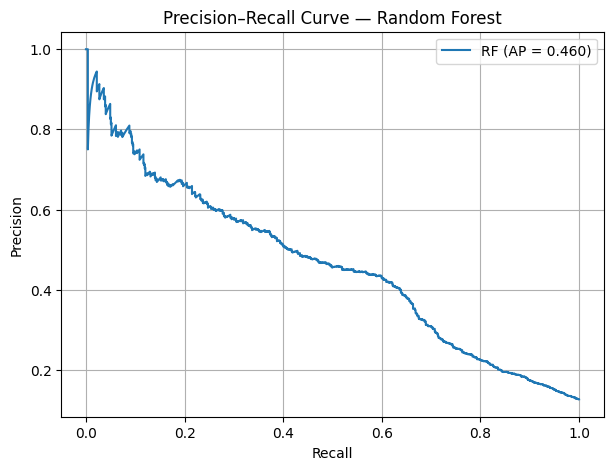

In [370]:
plt.figure(figsize=(7, 5))
plt.plot(rfc_recall, rfc_precision, label=f"RF (AP = {rfc_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.show()

#### Recall at Precision = 0.35

In [371]:
# Precision 0.35 with max recall (same as lr)

precision, recall, _ = precision_recall_curve(y_test, rfc_proba)
print(f"Random Forest: {recall[precision >= 0.35].max():.3f}")

Random Forest: 0.667


In [372]:
# Chosen parameter for artifact = 0.35
# Accompanying threshold = 0.467, meaning a call gets made when model predicts y=1 with 46.7% certainty

rfc_threshold = threshold_at_precision(y_test, rfc_proba, 0.35)

print("threshold", rfc_threshold)


threshold 0.4667112977514637


#### Confusion Matrix & Classification Report

In [373]:
# Model performance with chosen parameter

y_pred_rfc = (rfc_proba >= rfc_threshold).astype(int)

confusion_matrix(y_test, y_pred_rfc)

array([[4368,  956],
       [ 257,  515]])

In [374]:
print(classification_report(y_test, y_pred_rfc, digits=3))

              precision    recall  f1-score   support

           0      0.944     0.820     0.878      5324
           1      0.350     0.667     0.459       772

    accuracy                          0.801      6096
   macro avg      0.647     0.744     0.669      6096
weighted avg      0.869     0.801     0.825      6096



### XGBoost

In [375]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

xgb_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [376]:
xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, xgb_proba)
xgb_ap = average_precision_score(y_test, xgb_proba)

#### ROC - AUC

In [377]:
xgb_AUC = roc_auc_score(y_test, xgb_proba)
xgb_AUC

0.8017346418408381

#### Precision-Recall curve

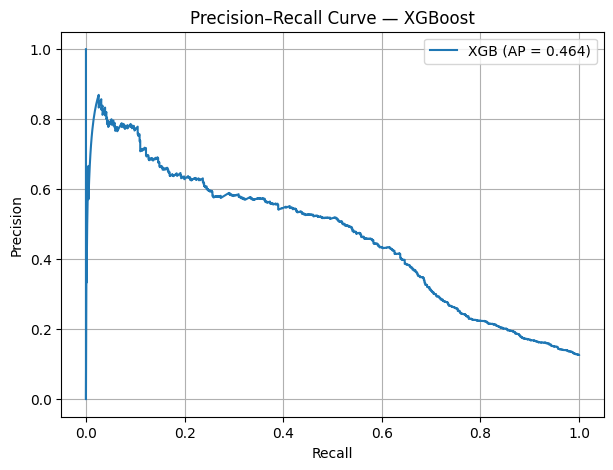

In [378]:
plt.figure(figsize=(7, 5))
plt.plot(xgb_recall, xgb_precision, label=f"XGB (AP = {xgb_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — XGBoost")
plt.legend()
plt.grid(True)
plt.show()

#### Recall at precision = 0.35

In [379]:
precision, recall, _ = precision_recall_curve(y_test, xgb_proba)
print(f"XGBoost: {recall[precision >= 0.35].max():.3f}")

XGBoost: 0.677


In [380]:
# Find threshold for precision >= 0.35 with max recall
xgb_threshold = threshold_at_precision(y_test, xgb_proba, 0.35)

print("threshold", xgb_threshold)

threshold 0.11625654


#### Confusion Matrix & Classification Report

In [381]:
# Predicitons at chosen threshold
y_pred_xgb = (xgb_proba >= xgb_threshold).astype(int)

# Evaluation
confusion_matrix(y_test, y_pred_xgb)

array([[4353,  971],
       [ 249,  523]])

In [382]:
print(classification_report(y_test, y_pred_xgb, digits=3))

              precision    recall  f1-score   support

           0      0.946     0.818     0.877      5324
           1      0.350     0.677     0.462       772

    accuracy                          0.800      6096
   macro avg      0.648     0.748     0.669      6096
weighted avg      0.870     0.800     0.824      6096



### Stacked models

In [383]:
stacked_clf = StackingClassifier(
    estimators=[
        ("lr", lr ),
        ("rf", rfc),
        ("xgb", xgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

In [384]:
stacked_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", stacked_clf)
])

stacked_pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

#### ROC - AUC

In [385]:
stacked_proba = stacked_pipe.predict_proba(X_test)[:, 1]

stacked_AUC = roc_auc_score(y_test, stacked_proba)
stacked_AUC

0.8014896373056994

#### Precision-Recall curve

In [386]:
# Precision-recall curve
stacked_precision, stacked_recall, stacked_thresholds = precision_recall_curve(
    y_test, stacked_proba)

stacked_ap = average_precision_score(y_test, stacked_proba)

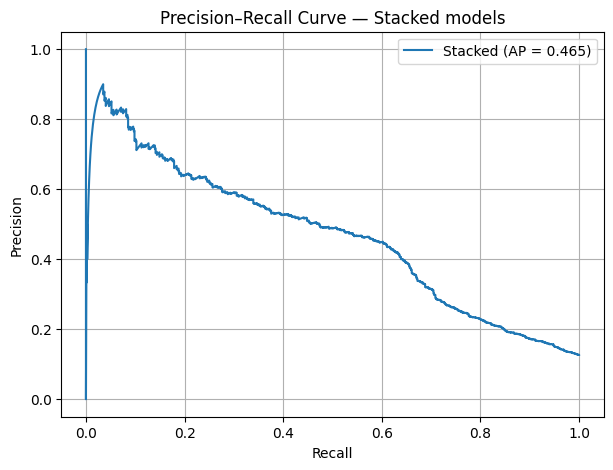

In [387]:
plt.figure(figsize=(7, 5))
plt.plot(stacked_recall, stacked_precision, label=f"Stacked (AP = {stacked_ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Stacked models")
plt.legend()
plt.grid(True)
plt.show()

#### Recall at Precision = 0.35

In [388]:
precision, recall, _ = precision_recall_curve(y_test, stacked_proba)
print(f"Stacked model: {recall[precision >= 0.35].max():.3f}")

Stacked model: 0.670


In [389]:
# threshold at precision >=0.35
stacked_threshold = threshold_at_precision(y_test, stacked_proba, 0.35)
print("threshold", stacked_threshold)

threshold 0.10382668419276028


#### Confusion Matrix & Classification Report

In [390]:
# Predictions at chosen threshold
y_pred_stacked = (stacked_proba >= stacked_threshold).astype(int)

# Evaluation
confusion_matrix(y_test, y_pred_stacked)

array([[4364,  960],
       [ 255,  517]])

In [391]:
# Although stacking improves recall over lr and rf, it does not substantially outperform XGBoost. This suggests that XGBoost already captures most non-linear structure present in the data.
print(classification_report(y_test, y_pred_stacked, digits=3))

              precision    recall  f1-score   support

           0      0.945     0.820     0.878      5324
           1      0.350     0.670     0.460       772

    accuracy                          0.801      6096
   macro avg      0.647     0.745     0.669      6096
weighted avg      0.869     0.801     0.825      6096



### Conclusion

#### Model comparison summary

At a fixed precision of 0.35, XGBoost achieves the highest recall (0.677),
followed closely by the stacked model (0.670). Logistic regression performs
worst under this constraint, confirming its role as a baseline model.

ROC-AUC scores further indicate that XGBoost provides the strongest overall
ranking performance, making it the preferred artifact.

In [392]:
# AUC for overall model performance
# ROC-AUC is reported as a supplementary metric to assess overall power, but model selection is based on recall under a fixed precision constraint.

print(f"Logistic Regression AUC: {roc_auc_score(y_test, lr_proba):.3f}")
print(f"Random Forest AUC:       {roc_auc_score(y_test, rfc_proba):.3f}")
print(f"XGBoost AUC:             {roc_auc_score(y_test, xgb_proba):.3f}")
print(f"Stacked model AUC:       {roc_auc_score(y_test, stacked_proba):.3f}")

Logistic Regression AUC: 0.788
Random Forest AUC:       0.798
XGBoost AUC:             0.802
Stacked model AUC:       0.801


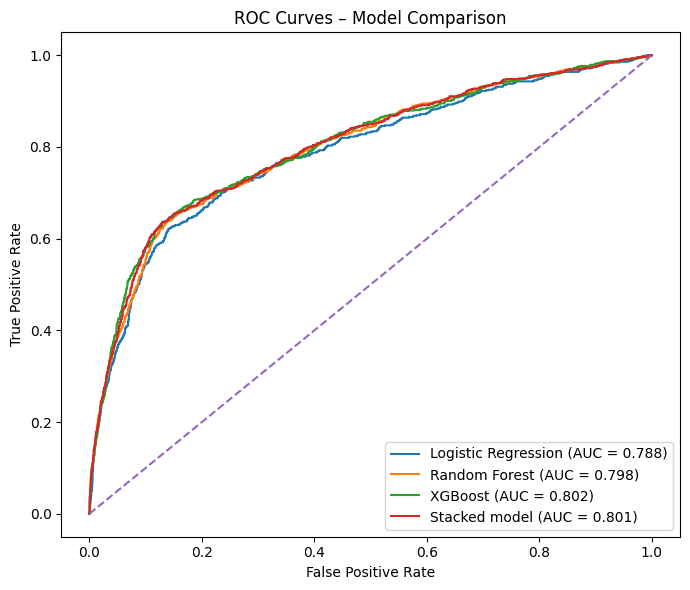

In [393]:
models = {
    "Logistic Regression": lr_proba,
    "Random Forest": rfc_proba,
    "XGBoost": xgb_proba,
    "Stacked model": stacked_proba
}

plt.figure(figsize=(7, 6))

for name, proba in models.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Model Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [394]:
# Recall for all models at precision 0.35

from sklearn.metrics import recall_score

print(f"Logistic Regression: {recall_score(y_test, (lr_proba >= lr_threshold).astype(int)):.3f}")
print(f"Random Forest:       {recall_score(y_test, (rfc_proba >= rfc_threshold).astype(int)):.3f}")
print(f"XGBoost:             {recall_score(y_test, (xgb_proba >= xgb_threshold).astype(int)):.3f}")
print(f"Stacked model:       {recall_score(y_test, (stacked_proba >= stacked_threshold).astype(int)):.3f}")

Logistic Regression: 0.637
Random Forest:       0.667
XGBoost:             0.677
Stacked model:       0.670


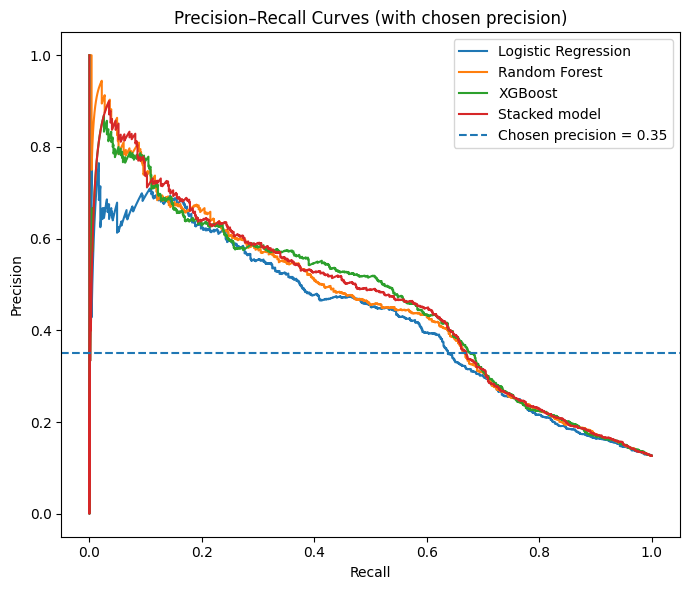

In [395]:
plt.figure(figsize=(7, 6))

models = {
    "Logistic Regression": lr_proba,
    "Random Forest": rfc_proba,
    "XGBoost": xgb_proba,
    "Stacked model": stacked_proba
}

for name, proba in models.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=name)

plt.axhline(
    y=0.35,
    linestyle="--",
    label="Chosen precision = 0.35"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (with chosen precision)")
plt.legend()
plt.tight_layout()
plt.show()


#### Artefact


XGBoost is selected as the final artifact due to its superior recall under the chosen precision constraint (and in lesser weight its AUC) and strong overall performance.

### Hyperparameter tuning

After model selection, the best performing model (Xgboost) is tuned

In [396]:
# Set scale weight to weigh FN more heavily in XGBoost

n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

scale_pos_weight = n_neg / n_pos
scale_pos_weight

np.float64(6.900842514581983)

In [397]:
from xgboost import XGBClassifier

xgb_tuned = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)


In [398]:
xgb_tuned_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb_tuned)
])

xgb_tuned_pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [399]:
xgb_tuned_proba = xgb_tuned_pipe.predict_proba(X_test)[:, 1]

xgb_tuned_AUC = roc_auc_score(y_test, stacked_proba)
xgb_tuned_AUC

0.8014896373056994

#### Recall at precision = 0.35

Hyperparameter tuning improved overall discrimination (AUC), but did not further improve recall at the chosen operational precision of 0.35. This illustrates that global optimisation metrics do not necessarily translate into gains at a fixed decision threshold.

XGBoost:            AUC:0.801                P@R0.35: 0.677
XGBoost Tuned:      AUC:0.801                P@R0.35: 0.667 



In [400]:
precision, recall, _ = precision_recall_curve(y_test, xgb_tuned_proba)
print(f"XGBoost: {recall[precision >= 0.35].max():.3f}")


XGBoost: 0.667


In [401]:
# Find threshold for precision >= 0.35 with max recall
xgb_tuned_threshold = threshold_at_precision(y_test, xgb_tuned_proba, 0.35)

print("threshold", xgb_tuned_threshold)

threshold 0.45990378


#### Confusion Matrix and Classification Report

In [402]:
# Predictions at chosen threshold
y_pred_xgb_tuned = (xgb_tuned_proba >= xgb_tuned_threshold).astype(int)

# Evaluation
confusion_matrix(y_test, y_pred_xgb_tuned)

array([[4368,  956],
       [ 257,  515]])

In [403]:
print(classification_report(y_test, y_pred_xgb_tuned, digits=3))

              precision    recall  f1-score   support

           0      0.944     0.820     0.878      5324
           1      0.350     0.667     0.459       772

    accuracy                          0.801      6096
   macro avg      0.647     0.744     0.669      6096
weighted avg      0.869     0.801     0.825      6096



#### TP rate of all models
Lr:492

Rf:515

XGB: 523

Stacked: 517

Tuned XGB: 515

Unfortunately scale_pos_weight does not maximize at our desired point (precision 0.35) and tuned is therefore outperformed by non tuned

### Attempt at minimizing loss with GridsearchCV

In [407]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

param_dist = {
    "classifier__n_estimators": [200, 300, 500],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.03, 0.05, 0.1],
    "classifier__subsample": [0.7, 0.8, 1.0],
    "classifier__colsample_bytree": [0.7, 0.8, 1.0],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,
    scoring="average_precision",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_xgb = search.best_estimator_



Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [408]:
best_xgb

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [409]:
xgb_tuned_proba = best_xgb.predict_proba(X_test)[:, 1]


In [410]:
precision, recall, _ = precision_recall_curve(y_test, xgb_tuned_proba)
recall_at_035 = recall[precision >= 0.35].max()

print(f"Tuned XGBoost: {recall_at_035:.3f}")

Tuned XGBoost: 0.674


In [413]:
# threshold bepalen
precision, recall, thresholds = precision_recall_curve(y_test, xgb_tuned_proba)
precision, recall = precision[:-1], recall[:-1]

mask = precision >= 0.35
best_idx = np.argmax(recall[mask])
xgb_tuned_threshold = thresholds[mask][best_idx]

# voorspellingen
y_pred_xgb_tuned = (xgb_tuned_proba >= xgb_tuned_threshold).astype(int)

confusion_matrix(y_test, y_pred_xgb_tuned)


array([[4359,  965],
       [ 252,  520]])

In [414]:
print(classification_report(y_test, y_pred_xgb_tuned, digits=3))

              precision    recall  f1-score   support

           0      0.945     0.819     0.878      5324
           1      0.350     0.674     0.461       772

    accuracy                          0.800      6096
   macro avg      0.648     0.746     0.669      6096
weighted avg      0.870     0.800     0.825      6096

